In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.stats import multivariate_normal

In [2]:
@njit
def det(u):
    alpha, beta = u
    return 1.5*alpha + 0.25*(beta-1)**2 + np.cos(np.pi+alpha+beta)

@njit
def func(u):
    alpha, beta = u
    return det(alpha,beta)+np.random.normal(0,0.1)

def prior(u,sigma=0.25):
    return multivariate_normal.pdf(u, mean = [0,4], cov = sigma)

@njit
def proposal(u,sigma):
    alpha, beta = u
    alpha = alpha + np.random.normal(0,sigma)
    beta = beta + np.random.normal(0,sigma)
    return np.array([alpha, beta])

def likelihood_ratio(u_prop,u,data,sigma=0.1):
    u_prop_sum = np.sum(np.subtract(data,det(u_prop))**2)
    u_sum = np.sum(np.subtract(data,det(u))**2)
    return np.exp(1/(2*sigma**2) * (-u_prop_sum + u_sum))

def accept_prob(u_prop,u,data):
    ratio = prior(u_prop)/prior(u)
    ratio = ratio * likelihood_ratio(u_prop,u,data)
    return np.min([1,ratio])

def metropolis_hastings(steps,data,sigma=1,u0 = np.array([0,0])):
    samples = np.zeros((steps+1,2))
    probs = np.zeros(steps)
    samples[0] = u0

    accepted = 0
    for i in range(steps):
        
        u_prop = proposal(samples[i],sigma)
        probs[i] = accept_prob(u_prop, samples[i],data)

        if probs[i] >= np.random.rand():
            samples[i+1] = u_prop
            accepted += 1
        else:
            samples[i+1] = samples[i]

    print(accepted/steps)
    return samples, probs

data = [4.02, 3.97, 4.05, 3.85, 3.94]

In [12]:
N = 1000
a = np.linspace(-10,10,N)
b = np.linspace(-10,10,N)
deterministic_out = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        deterministic_out[i,j] = det(np.array([a[i],b[j]]))

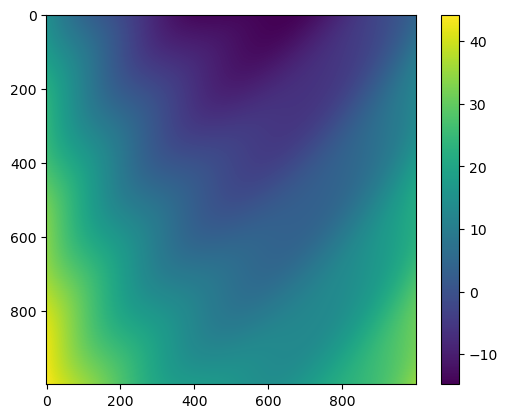

In [13]:
plt.imshow(deterministic_out)
plt.colorbar()

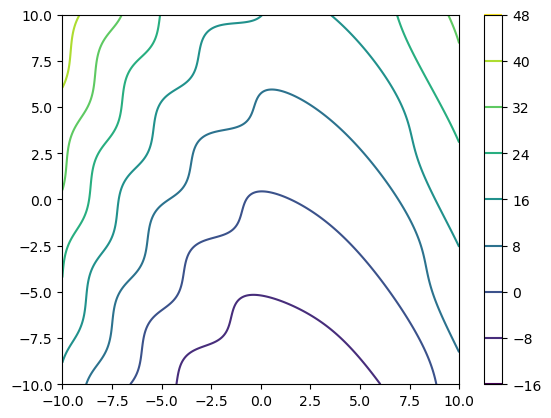

In [14]:
A,B = np.meshgrid(a,b)
plt.contour(A,B,deterministic_out)
plt.colorbar()

In [15]:
samples, probs = metropolis_hastings(100_000,data,sigma=0.1)

/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_37816/119475529.py:24: RuntimeWarning: overflow encountered in exp
  return np.exp(1/(2*sigma**2) * (-u_prop_sum + u_sum))


0.35313


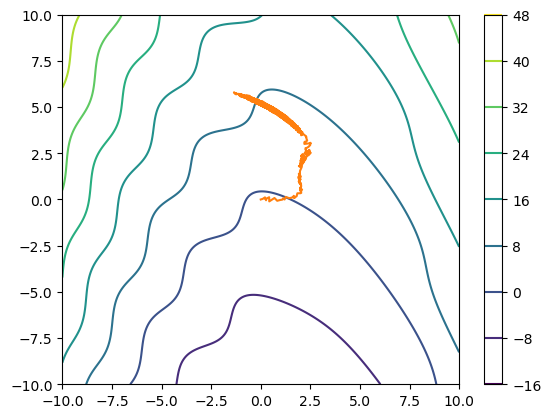

In [35]:
plt.contour(A,B,deterministic_out)
plt.colorbar()
plt.plot(samples[:,0],samples[:,1], c='C1')

In [28]:
det_samp = np.zeros(len(samples))

for i, sample in enumerate(samples):
    det_samp[i] = det(sample)

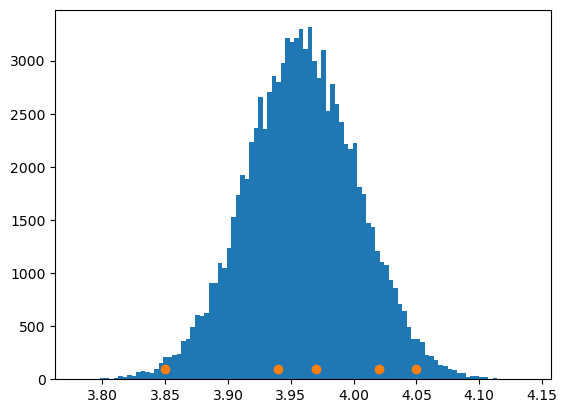

In [34]:
plt.hist(det_samp[1000:], bins=100)
plt.scatter(data, 100*np.ones_like(data),c='C1')